<a href="https://colab.research.google.com/github/nshah-waripari/nlp_transformers/blob/main/sentiment_classifier_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Classifier With Transformer Model Based On Hugging Face Ecosystem**
We will build the classifier using a variant of BERT [One of the pre-trained transformer models] called DistilBERT:[V. Sanh et al., "DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter", (2019).] The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient. 

In [1]:
# Install the required libraries
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter2=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 422 (delta 0), reused 5 (delta 0), pack-reused 416
Receiving objects: 100% (422/422), 24.97 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (190/190), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


# **Dataset**
We will use the tweeter emotion dataset hosted at hugging face from [E. Saravia et al., "CARER: Contextualized Affect Representations for Emotion Recognition," Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (Oct–Nov 2018): 3687–3697, http://dx.doi.org/10.18653/v1/D18-1404.] Unlike Imdb Sentiment Analysis dataset which involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise.

In [2]:
#list_dataset() function list the available datasets in the hugging face hub
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")


There are 7816 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
# Load emotion dataset from hugging face hub
from datasets import load_dataset
emotions = load_dataset('emotion')

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Emotions dataset is basically python dictionary, with each key corresponding to a different split

In [5]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
print(emotions['train'].features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


Looking at the "fetures" attributes of the dataset object,the data type of the text column is string, while the label column is a special ClassLabel object that contains information about the class names and their mapping to integers.

# **Convert Datasets to DataFrames**
It is often easier to convert DataSet object to Pandas DataFrame object which provides high-level APIs for data visualization

In [7]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names:

In [8]:
def label_in2str(row):
  return emotions["train"].features["label"].int2str(row)
# apply the function to the entire dataframe
df['label_name'] = df['label'].apply(label_in2str)
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# **Looking at the data**
1. Class Distribution

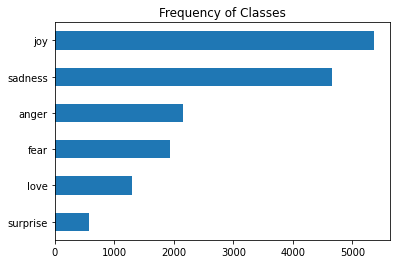

In [9]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

  2. How long are the tweets

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. Treating a token as a single word, we can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


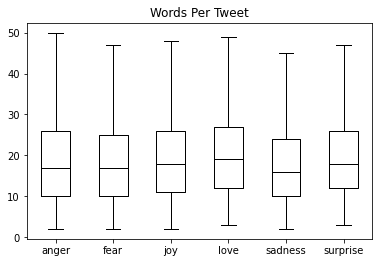

In [10]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

# **Tokenization**
Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.
### Subword Tokenization
The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.
There are several subword tokenization algorithms that are commonly used in NLP, but we will use WordPiece

In [11]:
# Load the tokenizer associated with pretrained model using AutoTokenizer class
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased' # model check point
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# let's examine how the tokenizer works
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [12]:
# in case the model does not load properly, remove the old model from cache folder
# !rm ~/.cache/huggingface/transformers/*


Words have been mapped to unique integers in the input_ids field.

In [13]:
# convert the token id back to token
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


Some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let's apply it to our tokens:

In [14]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [15]:
# AutoTokenizer class has some important attributes like
# vocab size
print(tokenizer.vocab_size)
# max length based on model's context
print(tokenizer.model_max_length)
# tokenizer's field names
print(tokenizer.model_input_names)


30522
512
['input_ids', 'attention_mask']


### Tokenizing the entire Dataset

In [16]:
# a function to tokenize the text in batch
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# emotions["train"][:2]["text"]

In [17]:
# reset the output format of emotions dataset since 
# we don't require DataFrame format anymore and is not compatible with Tranformers either
emotions.reset_format()
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Here we can see the result of padding: the first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length. These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [18]:
# get the ids of the special tokens
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key = lambda x: x[-1])
df = pd.DataFrame(data, columns = ["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


### Attention Mask
In addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. The image below provides a visual explanation of how the input IDs and attention masks are padded.
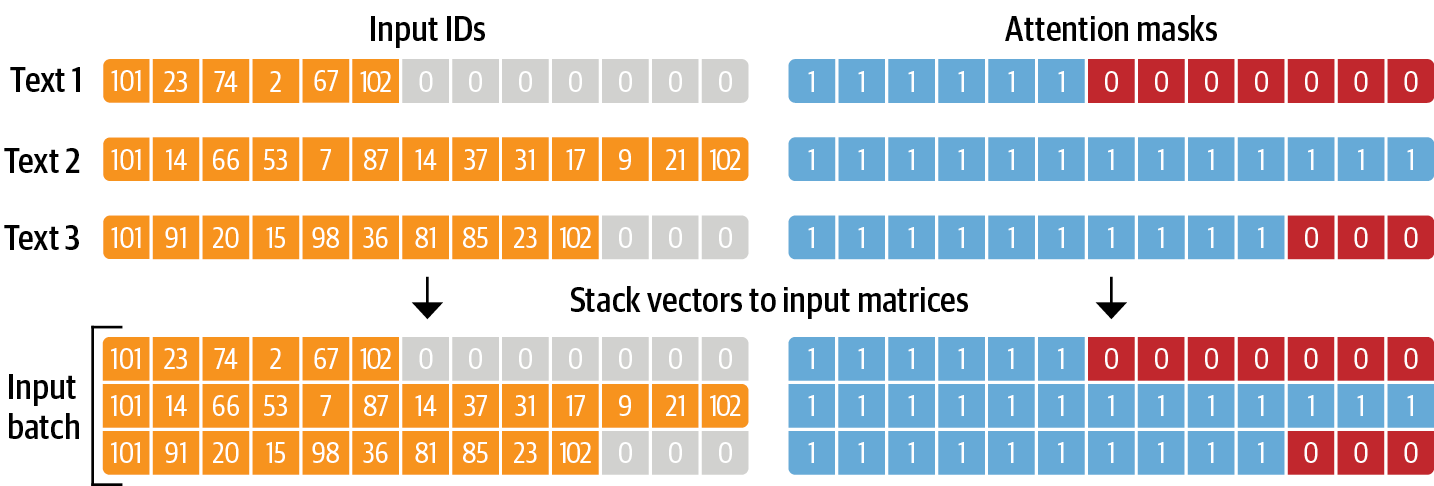


In [19]:
# Apply the tokenization to the entire dataset using map function
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None) # batch_size = None will appy the tokenizaton to the entire dataset

Parameter 'function'=<function tokenize at 0x7fa22bf98680> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
print(emotions_encoded["train"].column_names)

['attention_mask', 'input_ids', 'label', 'text']


# **Training a Text Classifier**
### 1. Transformers as Feature Extractors
We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
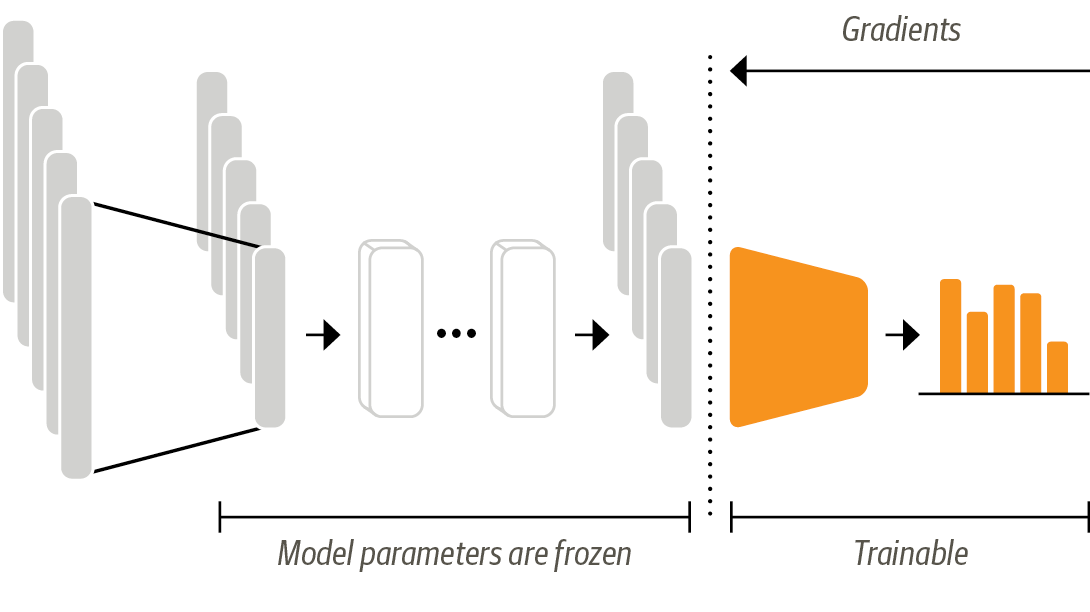

In [21]:
# Using pretrained models
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extracting the last hidden states


In [22]:
# first step encode the text and convert the tokens to pytorch tensors
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [23]:
# put the output tensor to the same device and pass them through the model
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


The model output is an instance of BaseModelOutput and we can access the attributes by its names

In [24]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

The outptus tensor has the shape [batch_size, n_tokens]. The output has a 768-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [25]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now that we know how to get the last hidden state for a single string, let's do the same thing for the whole dataset by creating a new hidden_state column that stores all these vectors.

In [26]:
# a function to extract hidden state from a batch
def extract_hidden_states(batch):
  # place model inputs into GPU
  inputs = {k:v.to(device) for k, v in batch.items()
  if k in tokenizer.model_input_names}
  # extract the hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # return vector for [CLS] token
  # place the final hidden state back on the CPU as a NumPy array. 
  # The map() method requires the processing function to return Python or NumPy objects when we're using batched inputs.
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Since our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format, as follows:

In [27]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 2000
    })
})

In [28]:
# extract hidden states across the entire dataset
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [29]:
emotions_hidden["train"].column_names

['attention_mask', 'hidden_state', 'input_ids', 'label', 'text']

### Creating a feature matrix
We will use the hidden states as input features and the labels as targets.

In [30]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set
Using UMAP algorithm to project 768 dimensions hidden states to 2D vector

In [31]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# scale features to [0,1]
X_scaled = MinMaxScaler().fit_transform(X_train)
# initialized and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# create a dataframe of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.121471,6.918758,0
1,-2.818999,5.940885,0
2,5.086709,3.560236,3
3,-2.355925,4.072922,2
4,-3.219842,4.075014,3


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

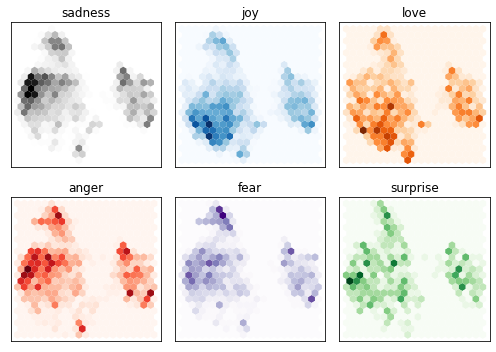

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]),axes[i].set_yticks([])
plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. On the other hand, joy and love are well separated from the negative emotions and also share a similar space. Finally, surprise is scattered all over the place.

### Training a simple classifier

In [33]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

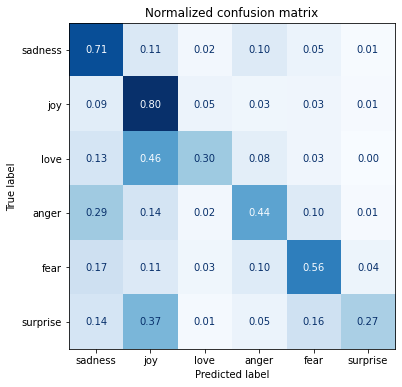

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

### 2. Fine Tuning Transformers
With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in figure below
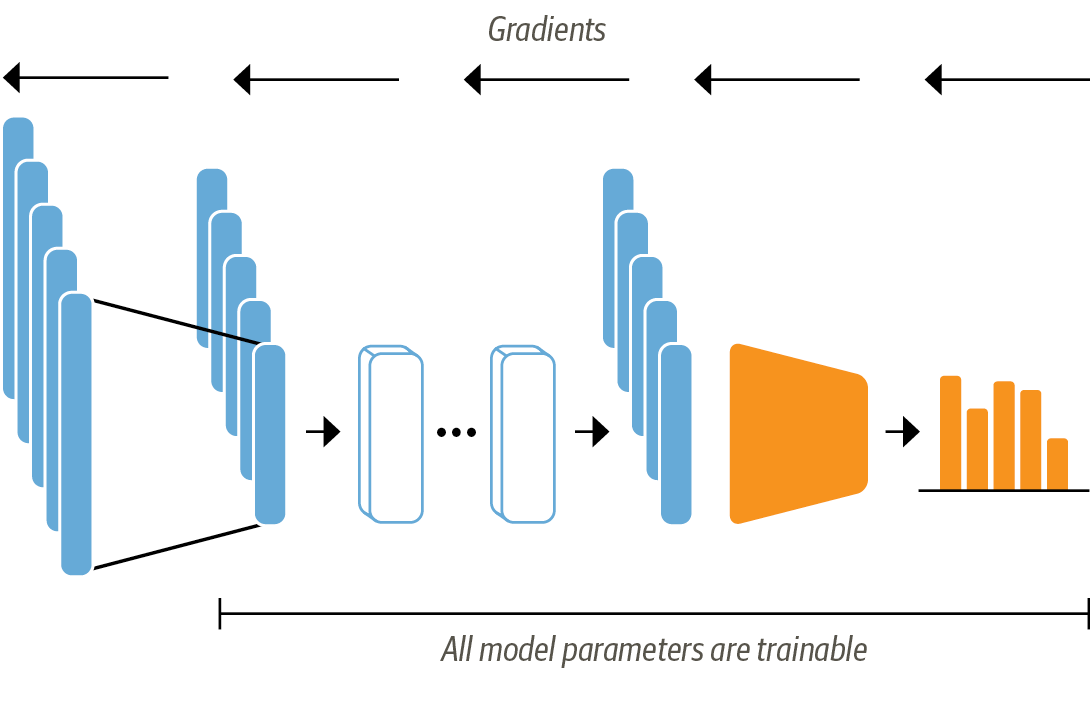

### Loading a pretrained model
We will load DistilBERT model for fine tuning and use **AutoModelForSequenceClassification** class for fine tune the model. **AutoModelForSequenceClassification** model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:


In [35]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model1 = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels).to(device))
print(device)


# num_labels = 6
# model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

cuda


### Defining the performance metrics
Compute F1 Score and Accuracy

In [36]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1":f1}

### Training the model

In [37]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [38]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs = 2, 
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    evaluation_strategy = "epoch",
    disable_tqdm = False,
    logging_steps = logging_steps,
    push_to_hub = True,
    log_level = "error"
)

In [39]:
from transformers import Trainer

trainer = Trainer(model = model1, args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset = emotions_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train();

Cloning https://huggingface.co/d2niraj555/distilbert-base-uncased-finetuned-emotion into local empty directory.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.808700,0.306668,0.905000,0.903022
2,0.243900,0.213314,0.924000,0.924133


Fine-tuned model has an -score on the validation set of around 92% - this is a significant improvement over the feature-based approach!



In [40]:
# access the prediction output attributes
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_accuracy': 0.924,
 'test_f1': 0.9241328800048197,
 'test_loss': 0.21331405639648438,
 'test_runtime': 5.7553,
 'test_samples_per_second': 347.504,
 'test_steps_per_second': 5.56}

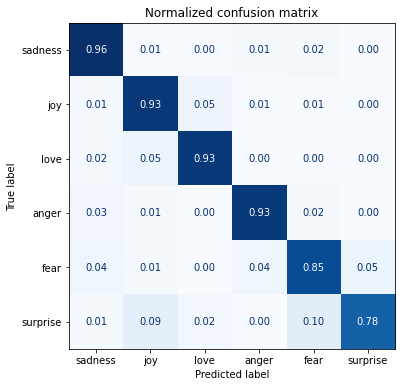

In [41]:
# plot the confusion matrix with the predictions
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)


This is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear. 

**Saving and sharing the model**

In [42]:
trainer.push_to_hub(commit_message="Training completed on fine tuned DistilBert Model for Emotion Classificaiton")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Jul27_17-11-47_c36a69348d86/events.out.tfevents.1658941928.c36a69348d86.71.0:  70%|#######   …

To https://huggingface.co/d2niraj555/distilbert-base-uncased-finetuned-emotion
   4be429b..86ba3f2  main -> main

   4be429b..86ba3f2  main -> main

To https://huggingface.co/d2niraj555/distilbert-base-uncased-finetuned-emotion
   86ba3f2..d9e838a  main -> main

   86ba3f2..d9e838a  main -> main



'https://huggingface.co/d2niraj555/distilbert-base-uncased-finetuned-emotion/commit/86ba3f2bf6b1e10f69020d2cd91efbe59e721fa8'

Use fine-tuned model to make prediction on new tweets

In [44]:
from transformers import pipeline
model_id = 'd2niraj555/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline("text-classification", model=model_id)

custom_tweet = "I am shocked to know that he is no more"
preds = classifier(custom_tweet, return_all_scores=True)

Plot the probability for each class in a bar plot

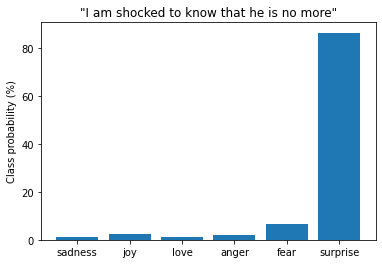

In [47]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color="C0")
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()